In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as mpl
from sklearn.metrics import r2_score
from io import StringIO
import glob
import os
import raytracing as rt
from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks, peak_widths
import scipy.optimize as spo
import scipy.constants as spc
import scipy.integrate as spi
import scipy.linalg as spl
import scipy.signal as spsi
import scipy.stats as spst

In [26]:
def lire_csv(chemin_fichier):
    """
    Lecture d'un fichier CSV avec une première ligne à ignorer,
    et renvoie un DataFrame pandas.

    Args:
        chemin_fichier (str): Le chemin d'accès vers le fichier CSV.

    Returns:
        pandas.DataFrame: Un DataFrame pandas contenant les données du fichier CSV.
    """
    # Lire le fichier en ignorant la première ligne
    with open(chemin_fichier, 'r', encoding='utf-8') as fichier:
        lignes = fichier.readlines()[1:]  # Ignorer la première ligne
    
    # Préparer le contenu transformé
    contenu_transforme = []
    for ligne in lignes:
        partie_gauche, _, partie_droite = ligne.partition(', ')  # Séparer à la première virgule
        partie_gauche, partie_droite = partie_gauche.replace(',', '.'), partie_droite.replace(',', '.')   # Au cas où, mais devrait être inutile ici
        ligne_transformee = partie_gauche + ';' + partie_droite
        contenu_transforme.append(ligne_transformee)
    
    # Convertir le contenu transformé en un objet StringIO
    contenu_csv = StringIO(''.join(contenu_transforme))
    
    # Lire le contenu transformé en DataFrame
    df = pd.read_csv(contenu_csv, names=['Pixels', 'Value'],sep=";")
    return df

In [27]:
def normalisation(df):
    """Fonction qui normalise les dataframes.

    Args:
        dataframe (DataFrame)

    Returns:
        DataFrame: Dataframe normalisé.
    """
    new_df = df.copy()
    column_name = new_df.columns[1]
    
    new_df[column_name] = (new_df[column_name]-min(new_df[column_name]))/np.ptp(new_df[column_name])
    
    return new_df

In [28]:

def pixel_to_cm_normalise(df, factor=0.25):
    """
    Multiplies the first column of a 2-column DataFrame by a specified factor.
    
    Parameters:
    - df: A pandas DataFrame with exactly 2 columns.
    - factor: The factor by which to multiply the first column.
    
    Returns:
    - A new DataFrame with the first column values multiplied by the factor.
    """
    # Ensure the DataFrame has exactly 2 columns
    if len(df.columns) != 2:
        raise ValueError("The DataFrame must have exactly 2 columns")
    
    # Create a copy of the DataFrame to avoid modifying the original
    new_df = df.copy()
    
    # Multiply the first column by the factor
    first_column_name = new_df.columns[0]
    new_df[first_column_name] = new_df[first_column_name] * factor
    
    second_column_name = new_df.columns[1]
    new_df[second_column_name] = (new_df[second_column_name]-min(new_df[second_column_name]))/np.ptp(new_df[second_column_name])
    
    return new_df

In [29]:
def find_peak_position(df, height_threshold=0.2):
    """
    Finds peaks based on the intensity column in a DataFrame, and calculates
    the mean position of these peaks.

    Parameters:
    - df: A pandas DataFrame with two columns, where the first column is 'position'
      and the second column is 'intensity'.
    
    Returns:
    - mean_peak_position: The mean position of the identified peaks.
    """
    # Identify peaks in the intensity column
    second_column_name = df.columns[1]
    peaks, _ = find_peaks(df[second_column_name],height=height_threshold)
    
    # Get the positions of these peaks
    first_column_name = df.columns[0]
    peak_positions = df.iloc[peaks][first_column_name]
    
    peak_width, peak_width_heigh, peak_width_left, peak_width_right = peak_widths(df[second_column_name],peaks,rel_height=height_threshold)
    
    return [np.array(peaks), np.array(peak_positions), np.array(df[second_column_name][peaks]), peak_width, peak_width_heigh, peak_width_left, peak_width_right]

In [30]:
def find_all_index_of_peaks(df, height=0.2):
    peaks, peak_position, peaks_value, peak_width, peak_width_heigh, peak_width_left, peak_width_right = find_peak_position(df,height_threshold=height)
    
    peak_separer = []
    i = 0
    for peak in peak_width_left:
        position_interval = []
        for j in range(len(df)):
            if float(j) >= float(peak) and float(j) < float(peak) + float(peak_width[i]):
                position_interval += [j]
        peak_separer += [position_interval]
        i+=1
    
    return peak_separer

In [31]:
def find_position_mean_std(df,echelle=0.025, height=0.2):
    
    peak_separer = find_all_index_of_peaks(df, height=height)
    moyennes = []
    stds = []
    for peak in peak_separer:
        moyennes += [np.mean(peak)]
        stds += [np.std(peak)]
        
    mean = []
    std = []
    for elem in moyennes :
        mean +=[elem * echelle]
    for elem in stds :
        std +=[elem * echelle]    
    return [mean, std]

In [32]:
def find_intensity_mean_std(df,height=0.2,reverse=False):
    
    peak_separer = find_all_index_of_peaks(df, height=height)
    mean_intensity = []
    std_intensity = []
    
    for peak in peak_separer:
        intensity = []
        for elem in peak:
            intensity += [df.iloc[elem,1]]
        if reverse == True :
            for i in range(len(intensity)):
                intensity[i] = np.abs(intensity[i]-1)
        mean_intensity += [np.mean(intensity)]
        std_intensity += [np.std(intensity)]
            
    
    return [mean_intensity , std_intensity]

In [33]:
def traitement_2d(df):
    second_column_name = df.columns[1]
    df[second_column_name] = np.abs(df[second_column_name]-1)
    return df

In [34]:
def subset(minimum_peaks, indice=[0]):
    subset_value,subset_std  = [],[]
    for elem in indice:
        subset_value += [minimum_peaks[0][elem]]
        subset_std += [minimum_peaks[1][elem]]
    return subset_value, subset_std

In [35]:
def mean_intensy_final(intensity,subsets):
    return [np.mean(subset(intensity,subsets)[0]),np.mean(subset(intensity,subsets)[1])]

In [36]:
def normalise_1d(list):
    list_v2 = []
    for elem in list:
        list_v2 += [(elem-min(list))/np.ptp(list)]
    return list_v2

In [37]:
def MTF(max, min):
    return [(max[0]-min[0])/(max[0]+min[0]), np.sqrt((min[0]*max[1]/(min[0]+max[0]))**2+(-max[0]*min[1]/(min[0]+max[0]))**2)]

In [38]:
def figure_plot_p4(df):
    mpl.figure(figsize=(12,6))
    mpl.plot(df["Pixels"],df["Value"], color="k")
    mpl.ylabel("Intensité normalisée [-]")
    mpl.xlabel("Position [mm]")
    # mpl.legend(frameon=False) 
    mpl.tick_params(axis='both', which='both', direction='in')
    mpl.minorticks_on()
    mpl.show()

# Données partie 4

## Données partie 4 x

In [39]:
# Données 2D
partie4_2d_x = lire_csv(r"partie_4/partie4_2d_x.csv")

# Données avec filtre Ramlack
partie4_3d_040_025_ramlack_x = lire_csv(r"partie_4/partie4_3d_040_025_ramlack_x.csv")
partie4_3d_040_025_ramlack_x_v2 = lire_csv(r"partie_4/partie4_3d_040_025_ramlack_x_v2.csv")
partie4_3d_160_025_ramlack_x = lire_csv(r"partie_4/partie4_3d_160_025_ramlack_x.csv")

# Influence de la résolution : 0,25 ; 0,50 ; 2,00
partie4_3d_320_025_x = lire_csv(r"partie_4/partie4_3d_320_025_x.csv")
partie4_3d_320_050_x = lire_csv(r"partie_4/partie4_3d_320_050_x.csv")
partie4_3d_320_200_x = lire_csv(r"partie_4/partie4_3d_320_200_x.csv")

## Données partie 4 y

In [40]:
# Données 2D
partie4_2d_y = traitement_2d(pixel_to_cm_normalise(lire_csv(r"partie_4/partie4_2d_y.csv")))

# Données avec filtre Ramlack
partie4_3d_040_025_ramlack_y_v2 = pixel_to_cm_normalise(lire_csv(r"partie_4/partie4_3d_040_025_ramlack_y_v2.csv"))
partie4_3d_040_025_ramlack_y = pixel_to_cm_normalise(lire_csv(r"partie_4/partie4_3d_040_025_ramlack_y.csv"))
partie4_3d_160_025_ramlack_y = pixel_to_cm_normalise(lire_csv(r"partie_4/partie4_3d_160_025_ramlack_y.csv"))

# Données avec diaphragme
partie4_3d_320_025_dia050_y = pixel_to_cm_normalise(lire_csv(r"partie_4/partie4_3d_320_025_dia050_y.csv"))
partie4_3d_320_025_dia150_y = pixel_to_cm_normalise(lire_csv(r"partie_4/partie4_3d_320_025_dia150_y.csv"))

# Données sans filtre
partie4_3d_320_025_nofilter_y = pixel_to_cm_normalise(lire_csv(r"partie_4/partie4_3d_320_025_nofilter_y.csv"))

# Influence de la résolution : 0,25 ; 0,50 ; 2,00
partie4_3d_320_025_y = pixel_to_cm_normalise(lire_csv(r"partie_4/partie4_3d_320_025_y.csv"))
partie4_3d_320_050_y = pixel_to_cm_normalise(lire_csv(r"partie_4/partie4_3d_320_050_y.csv"),0.5)
partie4_3d_320_200_y = pixel_to_cm_normalise(lire_csv(r"partie_4/partie4_3d_320_200_y.csv"), 2)

# Graphiques

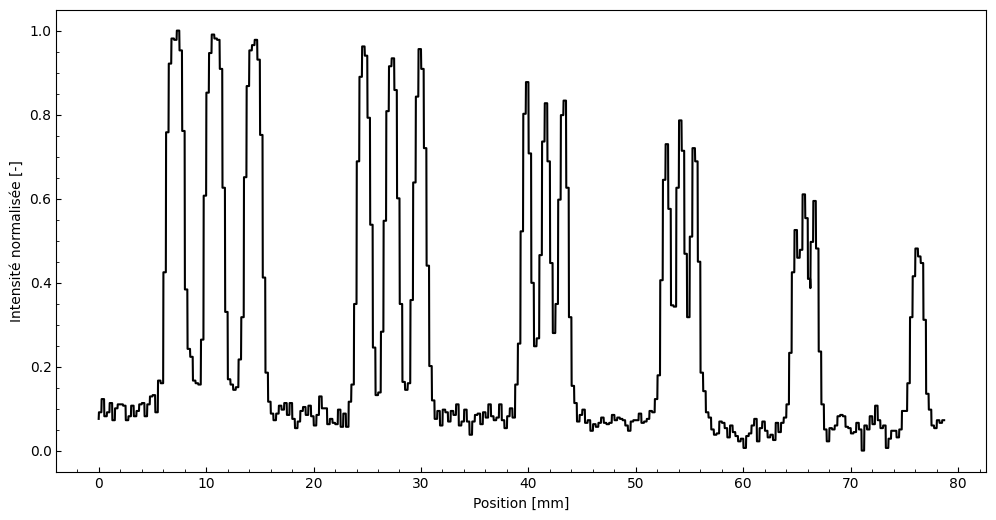

In [41]:
figure_plot_p4(partie4_2d_y)

position_max_partie4_2d_y = subset(find_position_mean_std(partie4_2d_y),[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
intensity_max_partie4_2d_y = subset(find_intensity_mean_std(partie4_2d_y),[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

reverse_partie4_2d_y = traitement_2d(partie4_2d_y)

position_min_partie4_2d_y = subset(find_position_mean_std(reverse_partie4_2d_y), [7,8,19,20,32,33,43,44,53,54])
intensity_min_partie4_2d_y = subset(find_intensity_mean_std(reverse_partie4_2d_y,reverse=True), [7,8,19,20,32,33,43,44,53,54])


intensity_max_groupe_1_partie4_2d_y = mean_intensy_final(intensity_max_partie4_2d_y,[0,1,2])
intensity_min_groupe_1_partie4_2d_y = mean_intensy_final(intensity_min_partie4_2d_y,[0,1])
mtf_groupe_1_partie4_2d_y = MTF(intensity_max_groupe_1_partie4_2d_y, intensity_min_groupe_1_partie4_2d_y)

intensity_max_groupe_2_partie4_2d_y = mean_intensy_final(intensity_max_partie4_2d_y,[3,4,5])
intensity_min_groupe_2_partie4_2d_y = mean_intensy_final(intensity_min_partie4_2d_y,[2,3])
mtf_groupe_2_partie4_2d_y= MTF(intensity_max_groupe_2_partie4_2d_y, intensity_min_groupe_2_partie4_2d_y)

intensity_max_groupe_3_partie4_2d_y = mean_intensy_final(intensity_max_partie4_2d_y,[6,7,8])
intensity_min_groupe_3_partie4_2d_y = mean_intensy_final(intensity_min_partie4_2d_y,[4,5])
mtf_groupe_3_partie4_2d_y= MTF(intensity_max_groupe_3_partie4_2d_y, intensity_min_groupe_3_partie4_2d_y)

intensity_max_groupe_4_partie4_2d_y = mean_intensy_final(intensity_max_partie4_2d_y,[9,10,11])
intensity_min_groupe_4_partie4_2d_y = mean_intensy_final(intensity_min_partie4_2d_y,[6,7])
mtf_groupe_4_partie4_2d_y= MTF(intensity_max_groupe_4_partie4_2d_y, intensity_min_groupe_4_partie4_2d_y)

intensity_max_groupe_5_partie4_2d_y = mean_intensy_final(intensity_max_partie4_2d_y,[12,13,14])
intensity_min_groupe_5_partie4_2d_y = mean_intensy_final(intensity_min_partie4_2d_y,[8,9])
mtf_groupe_5_partie4_2d_y= MTF(intensity_max_groupe_5_partie4_2d_y, intensity_min_groupe_5_partie4_2d_y)

mtfs_partie4_2d_y = normalise_1d([mtf_groupe_1_partie4_2d_y[0], mtf_groupe_2_partie4_2d_y[0], mtf_groupe_3_partie4_2d_y[0], mtf_groupe_4_partie4_2d_y[0], mtf_groupe_5_partie4_2d_y[0],0])
std_mts_partie4_2d_y = [mtf_groupe_1_partie4_2d_y[1], mtf_groupe_2_partie4_2d_y[1], mtf_groupe_3_partie4_2d_y[1], mtf_groupe_4_partie4_2d_y[1], mtf_groupe_5_partie4_2d_y[1],0]




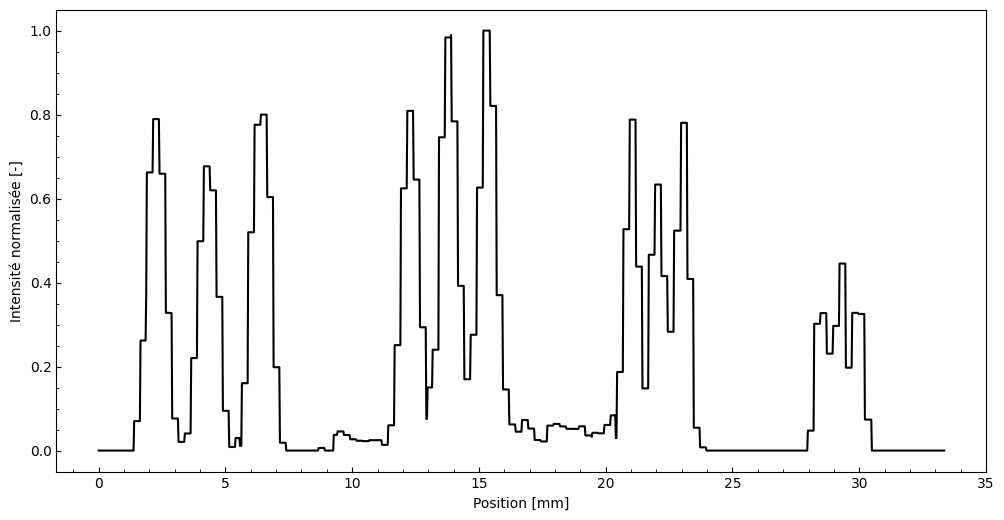

In [42]:
figure_plot_p4(partie4_3d_040_025_ramlack_y_v2)

position_max_partie4_3d_040_025_ramlack_y_v2 = find_position_mean_std(partie4_3d_040_025_ramlack_y_v2)
intensity_max_partie4_3d_040_025_ramlack_y_v2 = find_intensity_mean_std(partie4_3d_040_025_ramlack_y_v2)

reverse_partie4_3d_040_025_ramlack_y_v2 = traitement_2d(partie4_3d_040_025_ramlack_y_v2)
position_min_partie4_3d_040_025_ramlack_y_v2  = subset(find_position_mean_std(reverse_partie4_3d_040_025_ramlack_y_v2), [0,1,7,8,15,16,18,19])
intensity_min_partie4_3d_040_025_ramlack_y_v2  = subset(find_intensity_mean_std(partie4_3d_040_025_ramlack_y_v2,reverse=True), [0,1,7,8,15,16,18,19])


intensity_max_groupe_1_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_max_partie4_3d_040_025_ramlack_y_v2,[0,1,2])
intensity_min_groupe_1_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_min_partie4_3d_040_025_ramlack_y_v2,[0,1])
mtf_groupe_1_partie4_3d_040_025_ramlack_y_v2 = MTF(intensity_max_groupe_1_partie4_3d_040_025_ramlack_y_v2, intensity_min_groupe_1_partie4_3d_040_025_ramlack_y_v2)

intensity_max_groupe_2_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_max_partie4_3d_040_025_ramlack_y_v2,[3,4,5])
intensity_min_groupe_2_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_min_partie4_3d_040_025_ramlack_y_v2,[2,3])
mtf_groupe_2_partie4_3d_040_025_ramlack_y_v2 = MTF(intensity_max_groupe_2_partie4_3d_040_025_ramlack_y_v2, intensity_min_groupe_2_partie4_3d_040_025_ramlack_y_v2)

intensity_max_groupe_3_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_max_partie4_3d_040_025_ramlack_y_v2,[6,7,8])
intensity_min_groupe_3_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_min_partie4_3d_040_025_ramlack_y_v2,[4,5])
mtf_groupe_3_partie4_3d_040_025_ramlack_y_v2 = MTF(intensity_max_groupe_3_partie4_3d_040_025_ramlack_y_v2, intensity_min_groupe_3_partie4_3d_040_025_ramlack_y_v2)

intensity_max_groupe_4_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_max_partie4_3d_040_025_ramlack_y_v2,[9,10,11])
intensity_min_groupe_4_partie4_3d_040_025_ramlack_y_v2 = mean_intensy_final(intensity_min_partie4_3d_040_025_ramlack_y_v2,[6,7])
mtf_groupe_4_partie4_3d_040_025_ramlack_y_v2 = MTF(intensity_max_groupe_4_partie4_3d_040_025_ramlack_y_v2, intensity_min_groupe_4_partie4_3d_040_025_ramlack_y_v2)

mtfs_partie4_3d_040_025_ramlack_y_v2 = normalise_1d([mtf_groupe_1_partie4_3d_040_025_ramlack_y_v2[0], mtf_groupe_2_partie4_3d_040_025_ramlack_y_v2[0], mtf_groupe_3_partie4_3d_040_025_ramlack_y_v2[0], mtf_groupe_4_partie4_3d_040_025_ramlack_y_v2[0],0,0])
std_mts_partie4_3d_040_025_ramlack_y_v2 =[mtf_groupe_1_partie4_3d_040_025_ramlack_y_v2[1], mtf_groupe_2_partie4_3d_040_025_ramlack_y_v2[1], mtf_groupe_3_partie4_3d_040_025_ramlack_y_v2[1], mtf_groupe_4_partie4_3d_040_025_ramlack_y_v2[1],0,0]

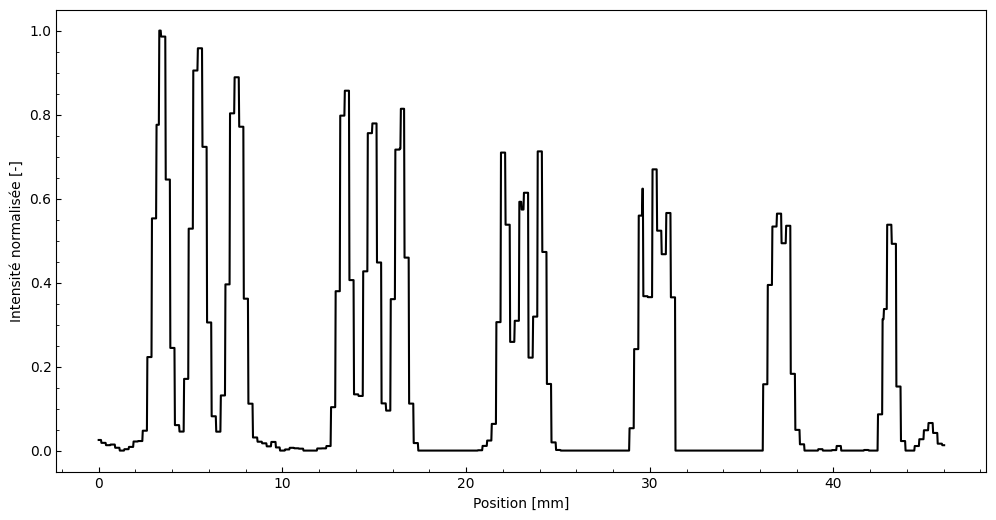

In [43]:
figure_plot_p4(partie4_3d_160_025_ramlack_y)

position_max_partie4_3d_160_025_ramlack_y = subset(find_position_mean_std(partie4_3d_160_025_ramlack_y),[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15])
intensity_max_partie4_3d_160_025_ramlack_y = subset(find_intensity_mean_std(partie4_3d_160_025_ramlack_y),[0,1,2,3,4,5,6,7,9,10,11,12,13,14,15])

reverse_partie4_3d_160_025_ramlack_y = traitement_2d(partie4_3d_160_025_ramlack_y)

position_min_partie4_3d_160_025_ramlack_y  = subset(find_position_mean_std(reverse_partie4_3d_160_025_ramlack_y), [2,3,7,8,10,12,14,15,17])
intensity_min_partie4_3d_160_025_ramlack_y  = subset(find_intensity_mean_std(partie4_3d_160_025_ramlack_y,reverse=True), [2,3,7,8,10,12,14,15,17])


intensity_max_groupe_1_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_max_partie4_3d_160_025_ramlack_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_min_partie4_3d_160_025_ramlack_y,[0,1])
mtf_groupe_1_partie4_3d_160_025_ramlack_y = MTF(intensity_max_groupe_1_partie4_3d_160_025_ramlack_y, intensity_min_groupe_1_partie4_3d_160_025_ramlack_y)

intensity_max_groupe_2_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_max_partie4_3d_160_025_ramlack_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_min_partie4_3d_160_025_ramlack_y,[2,3])
mtf_groupe_2_partie4_3d_160_025_ramlack_y = MTF(intensity_max_groupe_2_partie4_3d_160_025_ramlack_y, intensity_min_groupe_2_partie4_3d_160_025_ramlack_y)

intensity_max_groupe_3_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_max_partie4_3d_160_025_ramlack_y,[6,7,8])
intensity_min_groupe_3_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_min_partie4_3d_160_025_ramlack_y,[4,5])
mtf_groupe_3_partie4_3d_160_025_ramlack_y = MTF(intensity_max_groupe_3_partie4_3d_160_025_ramlack_y,intensity_min_groupe_3_partie4_3d_160_025_ramlack_y)

intensity_max_groupe_4_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_max_partie4_3d_160_025_ramlack_y,[9,10,11])
intensity_min_groupe_4_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_min_partie4_3d_160_025_ramlack_y,[6,7])
mtf_groupe_4_partie4_3d_160_025_ramlack_y = MTF(intensity_max_groupe_4_partie4_3d_160_025_ramlack_y,intensity_min_groupe_4_partie4_3d_160_025_ramlack_y)

intensity_max_groupe_5_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_max_partie4_3d_160_025_ramlack_y,[12,13])
intensity_min_groupe_5_partie4_3d_160_025_ramlack_y = mean_intensy_final(intensity_min_partie4_3d_160_025_ramlack_y,[8])
mtf_groupe_5_partie4_3d_160_025_ramlack_y = MTF(intensity_max_groupe_5_partie4_3d_160_025_ramlack_y,intensity_min_groupe_5_partie4_3d_160_025_ramlack_y)

mtfs_partie4_3d_160_025_ramlack_y = normalise_1d([mtf_groupe_1_partie4_3d_160_025_ramlack_y[0] , mtf_groupe_2_partie4_3d_160_025_ramlack_y[0], mtf_groupe_3_partie4_3d_160_025_ramlack_y[0], 
                                     mtf_groupe_4_partie4_3d_160_025_ramlack_y[0], mtf_groupe_5_partie4_3d_160_025_ramlack_y[0],0])
std_mtfs_partie4_3d_160_025_ramlack_y = [mtf_groupe_1_partie4_3d_160_025_ramlack_y[1] , mtf_groupe_2_partie4_3d_160_025_ramlack_y[1], mtf_groupe_3_partie4_3d_160_025_ramlack_y[1], 
                                     mtf_groupe_4_partie4_3d_160_025_ramlack_y[1], mtf_groupe_5_partie4_3d_160_025_ramlack_y[1],0]

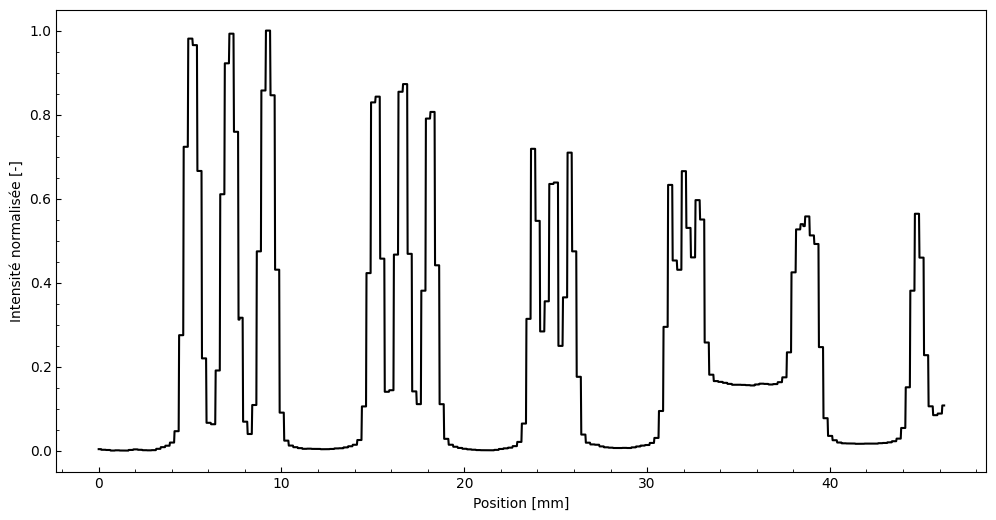

In [44]:
figure_plot_p4(partie4_3d_320_025_nofilter_y)

position_max_partie4_3d_320_025_nofilter_y = subset(find_position_mean_std(partie4_3d_320_025_nofilter_y,height=0.2),[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15])
intensity_max_partie4_3d_320_025_nofilter_y = subset(find_intensity_mean_std(partie4_3d_320_025_nofilter_y,height=0.2),[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15])

reverse_partie4_3d_320_025_nofilter_y = traitement_2d(partie4_3d_320_025_nofilter_y)

position_min_partie4_3d_320_025_nofilter_y  = subset(find_position_mean_std(reverse_partie4_3d_320_025_nofilter_y,height=0.2), [3,5,8,9,11,12,15,16,20])
intensity_min_partie4_3d_320_025_nofilter_y  = subset(find_intensity_mean_std(partie4_3d_320_025_nofilter_y,height=0.2,reverse=True), [3,5,8,9,11,12,15,16,20])

intensity_max_groupe_1_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_max_partie4_3d_320_025_nofilter_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_min_partie4_3d_320_025_nofilter_y,[0,1])
mtf_groupe_1_partie4_3d_320_025_nofilter_y = MTF(intensity_max_groupe_1_partie4_3d_320_025_nofilter_y,intensity_min_groupe_1_partie4_3d_320_025_nofilter_y)

intensity_max_groupe_2_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_max_partie4_3d_320_025_nofilter_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_min_partie4_3d_320_025_nofilter_y,[2,3])
mtf_groupe_2_partie4_3d_320_025_nofilter_y = MTF(intensity_max_groupe_2_partie4_3d_320_025_nofilter_y,intensity_min_groupe_2_partie4_3d_320_025_nofilter_y)

intensity_max_groupe_3_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_max_partie4_3d_320_025_nofilter_y,[6,7,8])
intensity_min_groupe_3_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_min_partie4_3d_320_025_nofilter_y,[4,5])
mtf_groupe_3_partie4_3d_320_025_nofilter_y = MTF(intensity_max_groupe_3_partie4_3d_320_025_nofilter_y,intensity_min_groupe_3_partie4_3d_320_025_nofilter_y)

intensity_max_groupe_4_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_max_partie4_3d_320_025_nofilter_y,[9,10,11])
intensity_min_groupe_4_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_min_partie4_3d_320_025_nofilter_y,[6,7])
mtf_groupe_4_partie4_3d_320_025_nofilter_y = MTF(intensity_max_groupe_4_partie4_3d_320_025_nofilter_y,intensity_min_groupe_4_partie4_3d_320_025_nofilter_y)

intensity_max_groupe_5_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_max_partie4_3d_320_025_nofilter_y,[12,13])
intensity_min_groupe_5_partie4_3d_320_025_nofilter_y = mean_intensy_final(intensity_min_partie4_3d_320_025_nofilter_y,[8])
mtf_groupe_5_partie4_3d_320_025_nofilter_y = MTF(intensity_max_groupe_5_partie4_3d_320_025_nofilter_y,intensity_min_groupe_5_partie4_3d_320_025_nofilter_y)

mtfs_partie4_3d_320_025_nofilter_y = normalise_1d([mtf_groupe_1_partie4_3d_320_025_nofilter_y[0], mtf_groupe_2_partie4_3d_320_025_nofilter_y[0], mtf_groupe_3_partie4_3d_320_025_nofilter_y[0]
                                      ,mtf_groupe_4_partie4_3d_320_025_nofilter_y[0],mtf_groupe_5_partie4_3d_320_025_nofilter_y[0],0])
std_mtfs_partie4_3d_320_025_nofilter_y = [mtf_groupe_1_partie4_3d_320_025_nofilter_y[1], mtf_groupe_2_partie4_3d_320_025_nofilter_y[1], mtf_groupe_3_partie4_3d_320_025_nofilter_y[1]
                                      ,mtf_groupe_4_partie4_3d_320_025_nofilter_y[1],mtf_groupe_5_partie4_3d_320_025_nofilter_y[1],0]

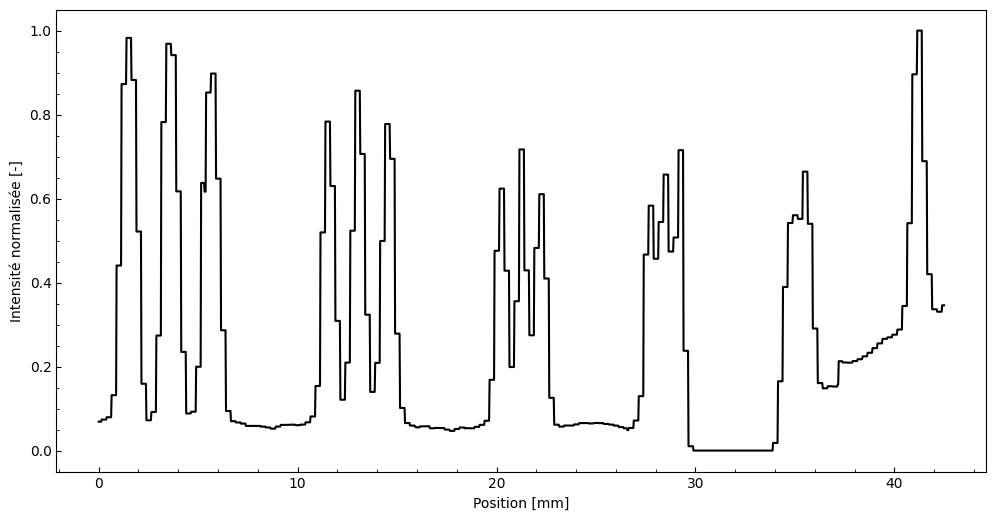

In [45]:
figure_plot_p4(partie4_3d_320_025_dia050_y)

position_max_partie4_3d_320_025_dia050_y = subset(find_position_mean_std(partie4_3d_320_025_dia050_y,height=0.2),[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15])
intensity_max_partie4_3d_320_025_dia050_y = subset(find_intensity_mean_std(partie4_3d_320_025_dia050_y,height=0.2),[0,1,3,4,5,6,7,8,9,10,11,12,13,14,15])

reverse_partie4_3d_320_025_dia050_y = traitement_2d(partie4_3d_320_025_dia050_y)

position_min_partie4_3d_320_025_dia050_y  = subset(find_position_mean_std(reverse_partie4_3d_320_025_dia050_y,height=0.2), [0,1,6,7,12,13,18,19,21])
intensity_min_partie4_3d_320_025_dia050_y  = subset(find_intensity_mean_std(partie4_3d_320_025_dia050_y,height=0.2,reverse=True), [0,1,6,7,12,13,18,19,21])


intensity_max_groupe_1_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia050_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia050_y,[0,1])
mtf_groupe_1_partie4_3d_320_025_dia050_y = MTF(intensity_max_groupe_1_partie4_3d_320_025_dia050_y,intensity_min_groupe_1_partie4_3d_320_025_dia050_y)

intensity_max_groupe_2_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia050_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia050_y,[2,3])
mtf_groupe_2_partie4_3d_320_025_dia050_y = MTF(intensity_max_groupe_2_partie4_3d_320_025_dia050_y,intensity_min_groupe_2_partie4_3d_320_025_dia050_y)

intensity_max_groupe_3_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia050_y,[6,7,8])
intensity_min_groupe_3_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia050_y,[4,5])
mtf_groupe_3_partie4_3d_320_025_dia050_y = MTF(intensity_max_groupe_3_partie4_3d_320_025_dia050_y,intensity_min_groupe_3_partie4_3d_320_025_dia050_y)

intensity_max_groupe_4_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia050_y,[9,10,11])
intensity_min_groupe_4_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia050_y,[6,7])
mtf_groupe_4_partie4_3d_320_025_dia050_y = MTF(intensity_max_groupe_4_partie4_3d_320_025_dia050_y,intensity_min_groupe_4_partie4_3d_320_025_dia050_y)

intensity_max_groupe_5_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia050_y,[12,13])
intensity_min_groupe_5_partie4_3d_320_025_dia050_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia050_y,[8])
mtf_groupe_5_partie4_3d_320_025_dia050_y = MTF(intensity_max_groupe_5_partie4_3d_320_025_dia050_y,intensity_min_groupe_5_partie4_3d_320_025_dia050_y)

mtfs_partie4_3d_320_025_dia050_y = normalise_1d([mtf_groupe_1_partie4_3d_320_025_dia050_y[0], mtf_groupe_2_partie4_3d_320_025_dia050_y[0], mtf_groupe_3_partie4_3d_320_025_dia050_y[0], 
                                    mtf_groupe_4_partie4_3d_320_025_dia050_y[0], 0,0])
std_mtfs_partie4_3d_320_025_dia050_y = [mtf_groupe_1_partie4_3d_320_025_dia050_y[1], mtf_groupe_2_partie4_3d_320_025_dia050_y[1], mtf_groupe_3_partie4_3d_320_025_dia050_y[1], 
                                    mtf_groupe_4_partie4_3d_320_025_dia050_y[1], 0,0]

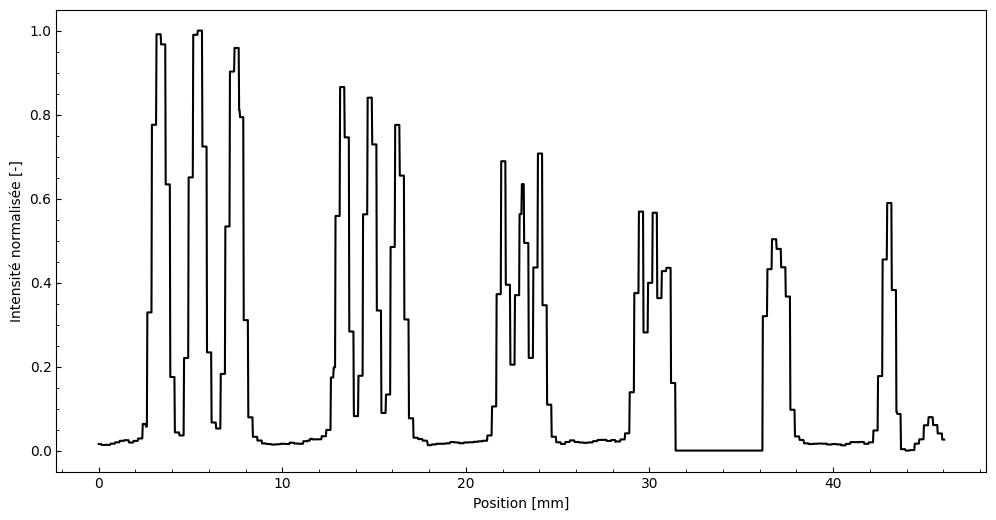

In [46]:
figure_plot_p4(partie4_3d_320_025_dia150_y)

position_max_partie4_3d_320_025_dia150_y = find_position_mean_std(partie4_3d_320_025_dia150_y,height=0.3)
intensity_max_partie4_3d_320_025_dia150_y = find_intensity_mean_std(partie4_3d_320_025_dia150_y,height=0.3)

reverse_partie4_3d_320_025_dia150_y = traitement_2d(partie4_3d_320_025_dia150_y)

position_min_partie4_3d_320_025_dia150_y  = subset(find_position_mean_std(reverse_partie4_3d_320_025_dia150_y,height=0.3), [3,4,9,10,13,14,19,20])
intensity_min_partie4_3d_320_025_dia150_y  = subset(find_intensity_mean_std(partie4_3d_320_025_dia150_y,height=0.3,reverse=True), [3,4,9,10,13,14,19,20])


intensity_max_groupe_1_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia150_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_320_025_dia150_y= mean_intensy_final(intensity_min_partie4_3d_320_025_dia150_y,[0,1])
mtf_groupe_1_partie4_3d_320_025_dia150_y = MTF(intensity_max_groupe_1_partie4_3d_320_025_dia150_y,intensity_min_groupe_1_partie4_3d_320_025_dia150_y)

intensity_max_groupe_2_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia150_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia150_y,[2,3])
mtf_groupe_2_partie4_3d_320_025_dia150_y = MTF(intensity_max_groupe_2_partie4_3d_320_025_dia150_y,intensity_min_groupe_2_partie4_3d_320_025_dia150_y)

intensity_max_groupe_3_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia150_y,[6,7,8])
intensity_min_groupe_3_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia150_y,[4,5])
mtf_groupe_3_partie4_3d_320_025_dia150_y = MTF(intensity_max_groupe_3_partie4_3d_320_025_dia150_y,intensity_min_groupe_3_partie4_3d_320_025_dia150_y)

intensity_max_groupe_4_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_max_partie4_3d_320_025_dia150_y,[9,10,11])
intensity_min_groupe_4_partie4_3d_320_025_dia150_y = mean_intensy_final(intensity_min_partie4_3d_320_025_dia150_y,[6,7])
mtf_groupe_4_partie4_3d_320_025_dia150_y = MTF(intensity_max_groupe_4_partie4_3d_320_025_dia150_y,intensity_min_groupe_4_partie4_3d_320_025_dia150_y)

mtfs_partie4_3d_320_025_dia150_y = normalise_1d([mtf_groupe_1_partie4_3d_320_025_dia150_y[0], mtf_groupe_2_partie4_3d_320_025_dia150_y[0]
                                    ,mtf_groupe_3_partie4_3d_320_025_dia150_y[0],mtf_groupe_4_partie4_3d_320_025_dia150_y[0],0,0])
std_mtfs_partie4_3d_320_025_dia150_y = [mtf_groupe_1_partie4_3d_320_025_dia150_y[1], mtf_groupe_2_partie4_3d_320_025_dia150_y[1]
                                    ,mtf_groupe_3_partie4_3d_320_025_dia150_y[1],mtf_groupe_4_partie4_3d_320_025_dia150_y[1],0,0]

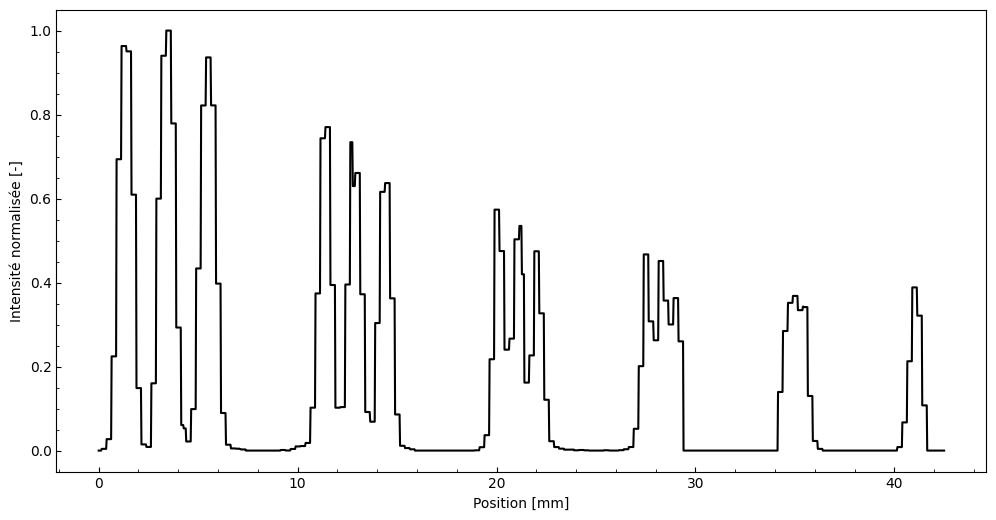

In [47]:
figure_plot_p4(partie4_3d_320_025_y)

position_max_partie4_3d_320_025_y = subset(find_position_mean_std(partie4_3d_320_025_y,height=0.2),[0,1,2,3,4,6,7,8,9,10,11,12,13,14,15])
intensity_max_partie4_3d_320_025_y = subset(find_intensity_mean_std(partie4_3d_320_025_y,height=0.2),[0,1,2,3,4,6,7,8,9,10,11,12,13,14,15])

reverse_partie4_3d_320_025_y = traitement_2d(partie4_3d_320_025_y)

position_min_partie4_3d_320_025_y  = subset(find_position_mean_std(reverse_partie4_3d_320_025_y,height=0.2), [0,1,4,6,9,10,15,16,18])
intensity_min_partie4_3d_320_025_y = subset(find_intensity_mean_std(partie4_3d_320_025_y,height=0.2,reverse=True), [0,1,4,6,9,10,15,16,18])

intensity_max_groupe_1_partie4_3d_320_025_y = mean_intensy_final(intensity_max_partie4_3d_320_025_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_320_025_y= mean_intensy_final(intensity_min_partie4_3d_320_025_y,[0,1])
mtf_groupe_1_partie4_3d_320_025_y = MTF(intensity_max_groupe_1_partie4_3d_320_025_y,intensity_min_groupe_1_partie4_3d_320_025_y)

intensity_max_groupe_2_partie4_3d_320_025_y= mean_intensy_final(intensity_max_partie4_3d_320_025_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_320_025_y = mean_intensy_final(intensity_min_partie4_3d_320_025_y,[2,3])
mtf_groupe_2_partie4_3d_320_025_y = MTF(intensity_max_groupe_2_partie4_3d_320_025_y,intensity_min_groupe_2_partie4_3d_320_025_y)

intensity_max_groupe_3_partie4_3d_320_025_y = mean_intensy_final(intensity_max_partie4_3d_320_025_y,[6,7,8])
intensity_min_groupe_3_partie4_3d_320_025_y = mean_intensy_final(intensity_min_partie4_3d_320_025_y,[4,5])
mtf_groupe_3_partie4_3d_320_025_y = MTF(intensity_max_groupe_3_partie4_3d_320_025_y,intensity_min_groupe_3_partie4_3d_320_025_y)

intensity_max_groupe_4_partie4_3d_320_025_y = mean_intensy_final(intensity_max_partie4_3d_320_025_y,[9,10,11])
intensity_min_groupe_4_partie4_3d_320_025_y = mean_intensy_final(intensity_min_partie4_3d_320_025_y,[6,7])
mtf_groupe_4_partie4_3d_320_025_y = MTF(intensity_max_groupe_4_partie4_3d_320_025_y,intensity_min_groupe_4_partie4_3d_320_025_y)

intensity_max_groupe_5_partie4_3d_320_025_y = mean_intensy_final(intensity_max_partie4_3d_320_025_y,[12,13])
intensity_min_groupe_5_partie4_3d_320_025_y = mean_intensy_final(intensity_min_partie4_3d_320_025_y,[8])
mtf_groupe_5_partie4_3d_320_025_y = MTF(intensity_max_groupe_5_partie4_3d_320_025_y,intensity_min_groupe_5_partie4_3d_320_025_y)

mtfs_partie4_3d_320_025_y = normalise_1d([mtf_groupe_1_partie4_3d_320_025_y[0],mtf_groupe_2_partie4_3d_320_025_y[0],
                             mtf_groupe_3_partie4_3d_320_025_y[0],mtf_groupe_4_partie4_3d_320_025_y[0],mtf_groupe_5_partie4_3d_320_025_y[0],0])
std_mtfs_partie4_3d_320_025_y = [mtf_groupe_1_partie4_3d_320_025_y[1],mtf_groupe_2_partie4_3d_320_025_y[1],
                             mtf_groupe_3_partie4_3d_320_025_y[1],mtf_groupe_4_partie4_3d_320_025_y[1],mtf_groupe_5_partie4_3d_320_025_y[1],0]

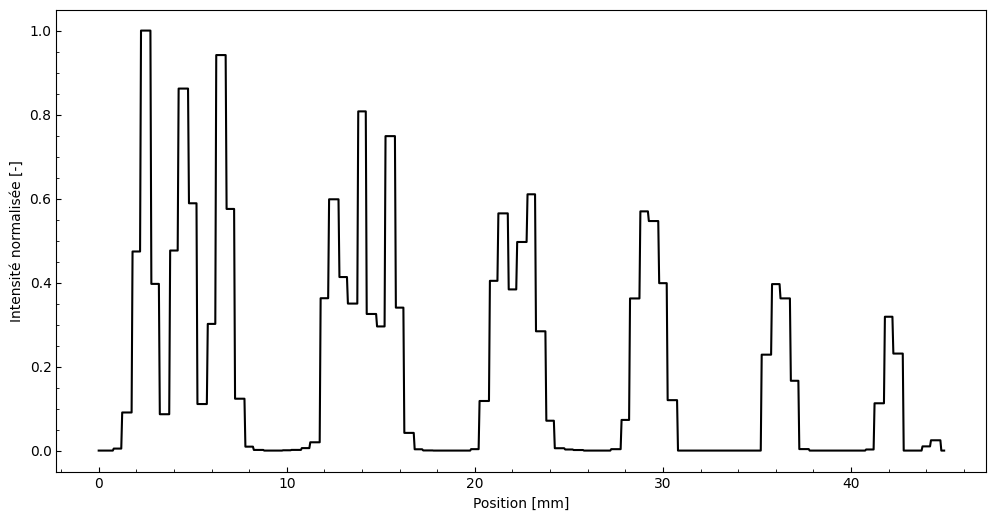

In [48]:
figure_plot_p4(partie4_3d_320_050_y)

position_max_partie4_3d_320_050_y = find_position_mean_std(partie4_3d_320_050_y,echelle=0.05,height=0.1)
intensity_max_partie4_3d_320_050_y = find_intensity_mean_std(partie4_3d_320_050_y,height=0.1)

reverse_partie4_3d_320_050_y = traitement_2d(partie4_3d_320_050_y)


position_min_partie4_3d_320_050_y  = subset(find_position_mean_std(reverse_partie4_3d_320_050_y,echelle=0.05,height=0.1),[0,1,3,4,6])
intensity_min_partie4_3d_320_050_y = subset(find_intensity_mean_std(partie4_3d_320_050_y,height=0.1,reverse=True),[0,1,3,4,6])

intensity_max_groupe_1_partie4_3d_320_050_y = mean_intensy_final(intensity_max_partie4_3d_320_050_y,[0,1,2])
intensity_min_groupe_1_partie4_3d_320_050_y = mean_intensy_final(intensity_min_partie4_3d_320_050_y,[0,1])
mtf_groupe_1_partie4_3d_320_050_y = MTF(intensity_max_groupe_1_partie4_3d_320_050_y,intensity_min_groupe_1_partie4_3d_320_050_y)

intensity_max_groupe_2_partie4_3d_320_050_y = mean_intensy_final(intensity_max_partie4_3d_320_050_y,[3,4,5])
intensity_min_groupe_2_partie4_3d_320_050_y = mean_intensy_final(intensity_min_partie4_3d_320_050_y,[2,3])
mtf_groupe_2_partie4_3d_320_050_y = MTF(intensity_max_groupe_2_partie4_3d_320_050_y,intensity_min_groupe_2_partie4_3d_320_050_y)

intensity_max_groupe_3_partie4_3d_320_050_y = mean_intensy_final(intensity_max_partie4_3d_320_050_y,[6,7])
intensity_min_groupe_3_partie4_3d_320_050_y = mean_intensy_final(intensity_min_partie4_3d_320_050_y,[4])
mtf_groupe_3_partie4_3d_320_050_y = MTF(intensity_max_groupe_3_partie4_3d_320_050_y,intensity_min_groupe_3_partie4_3d_320_050_y)

mtfs_partie4_3d_320_050_y = normalise_1d([mtf_groupe_1_partie4_3d_320_050_y[0],mtf_groupe_2_partie4_3d_320_050_y[0],mtf_groupe_3_partie4_3d_320_050_y[0],0,0,0])
std_mtfs_partie4_3d_320_050_y = [mtf_groupe_1_partie4_3d_320_050_y[1],mtf_groupe_2_partie4_3d_320_050_y[1],mtf_groupe_3_partie4_3d_320_050_y[1],0,0,0]

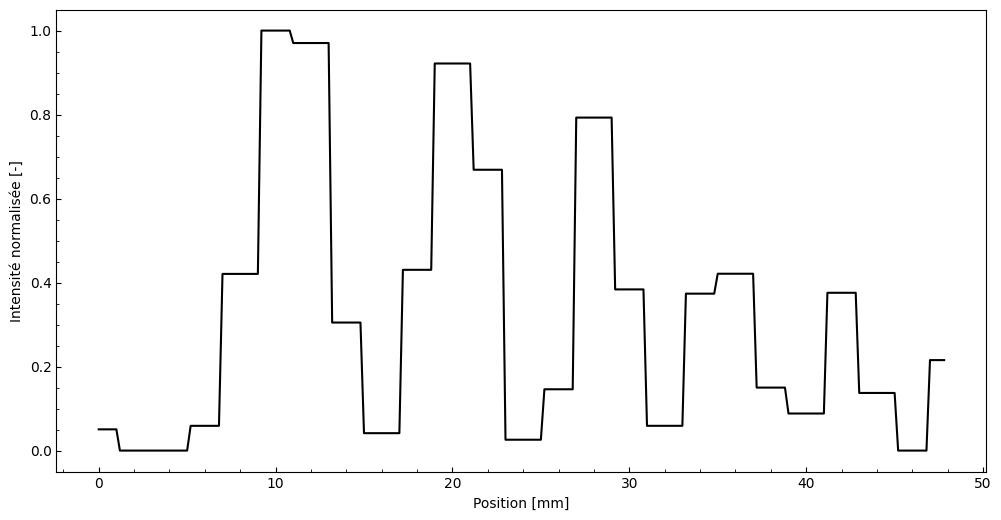

In [49]:
figure_plot_p4(partie4_3d_320_200_y)

# MTF

In [50]:
x_scale = [1/2, 1/1.5, 1 ,1/0.75,1/0.50,1/0.25]

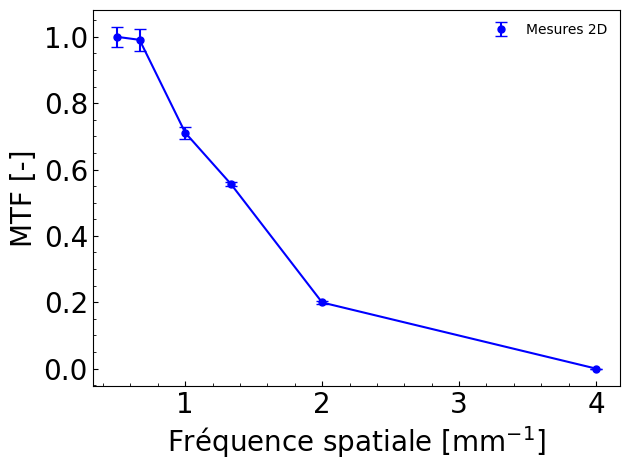

In [51]:
mpl.errorbar(x_scale, mtfs_partie4_2d_y, yerr=std_mts_partie4_2d_y, color="blue",fmt='o', capsize=4, markersize=5, linestyle='', label='Mesures 2D')
mpl.plot(x_scale, mtfs_partie4_2d_y, color="blue")
mpl.ylabel("MTF [-]", fontsize=20)
mpl.xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=20)
mpl.legend(frameon=False) 
mpl.tick_params(axis='both', which='both', direction='in', labelsize=20)
mpl.minorticks_on()
mpl.tight_layout()

mpl.show()

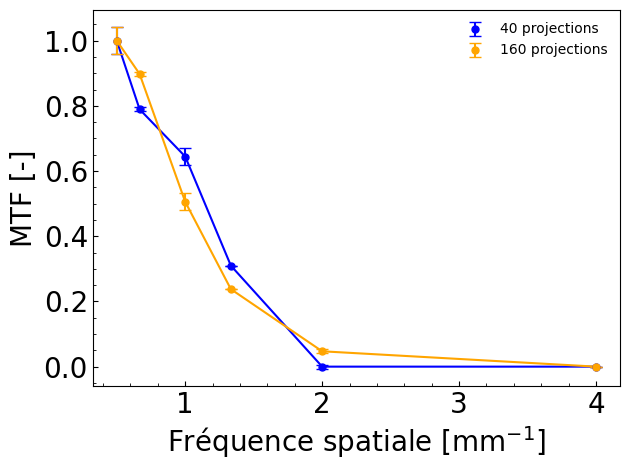

In [52]:
mpl.errorbar(x_scale, mtfs_partie4_3d_040_025_ramlack_y_v2, yerr=std_mtfs_partie4_3d_160_025_ramlack_y, 
             color="blue", fmt='o', capsize=4, markersize=5, linestyle='', label='40 projections')
mpl.plot(x_scale, mtfs_partie4_3d_040_025_ramlack_y_v2, color="blue")
mpl.errorbar(x_scale, mtfs_partie4_3d_160_025_ramlack_y, yerr=std_mtfs_partie4_3d_160_025_ramlack_y, 
             color="orange", fmt='o', capsize=4, markersize=5, linestyle='', label='160 projections')
mpl.plot(x_scale, mtfs_partie4_3d_160_025_ramlack_y, color="orange")
mpl.ylabel("MTF [-]", fontsize=20)
mpl.xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=20)
mpl.legend(frameon=False) 
mpl.tick_params(axis='both', which='both', direction='in', labelsize=20)
mpl.minorticks_on()
mpl.tight_layout()

mpl.show()

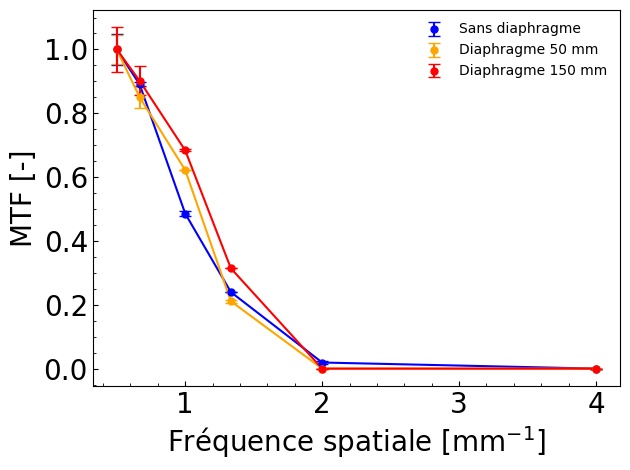

In [53]:
mpl.errorbar(x_scale, mtfs_partie4_3d_320_025_y, yerr=std_mtfs_partie4_3d_320_025_y, 
             color="blue", fmt='o', capsize=4, markersize=5, linestyle='', label='Sans diaphragme')
mpl.plot(x_scale, mtfs_partie4_3d_320_025_y,color="blue")
mpl.plot(x_scale, mtfs_partie4_3d_320_025_dia050_y, color="orange")
mpl.errorbar(x_scale, mtfs_partie4_3d_320_025_dia050_y, yerr=std_mtfs_partie4_3d_320_025_dia050_y, 
             color="orange",fmt='o', capsize=4, markersize=5, linestyle='', label='Diaphragme 50 mm')
mpl.plot(x_scale, mtfs_partie4_3d_320_025_dia150_y, color="red")
mpl.errorbar(x_scale, mtfs_partie4_3d_320_025_dia150_y, yerr=std_mtfs_partie4_3d_320_025_dia150_y, 
             color="red", fmt='o', capsize=4, markersize=5, linestyle='', label='Diaphragme 150 mm')
mpl.ylabel("MTF [-]", fontsize=20)
mpl.xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=20)
mpl.legend(frameon=False) 
mpl.tick_params(axis='both', which='both', direction='in', labelsize=20)
mpl.minorticks_on()
mpl.tight_layout()

mpl.show()

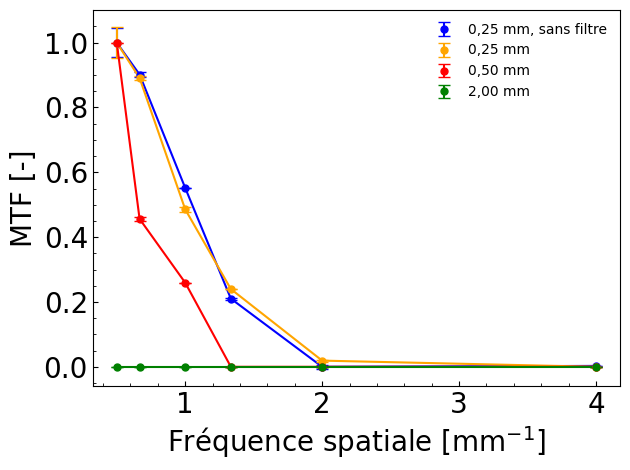

In [54]:
mpl.errorbar(x_scale, mtfs_partie4_3d_320_025_nofilter_y , std_mtfs_partie4_3d_320_025_nofilter_y, color="blue", fmt='o', capsize=4, markersize=5, linestyle='', label='0,25 mm, sans filtre')
mpl.plot(x_scale,mtfs_partie4_3d_320_025_nofilter_y  ,color="blue")
mpl.errorbar(x_scale, mtfs_partie4_3d_320_025_y, yerr=std_mtfs_partie4_3d_320_025_y, color="orange", fmt='o', capsize=4, markersize=5, linestyle='', label='0,25 mm')
mpl.plot(x_scale, mtfs_partie4_3d_320_025_y,color="orange")
mpl.errorbar(x_scale, mtfs_partie4_3d_320_050_y, yerr=std_mtfs_partie4_3d_320_050_y, color="red", fmt='o', capsize=4, markersize=5, linestyle='', label='0,50 mm')
mpl.plot(x_scale, mtfs_partie4_3d_320_050_y, color="red")
mpl.errorbar(x_scale, [0,0,0,0,0,0], yerr=[0,0,0,0,0,0], color="green", fmt='o', capsize=4, markersize=5, linestyle='', label='2,00 mm')
mpl.plot(x_scale,[0,0,0,0,0,0] ,color="green")

mpl.ylabel("MTF [-]", fontsize=20)
mpl.xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=20)
mpl.legend(frameon=False) 
mpl.tick_params(axis='both', which='both', direction='in', labelsize=20)
mpl.minorticks_on()
mpl.tight_layout()

mpl.show()

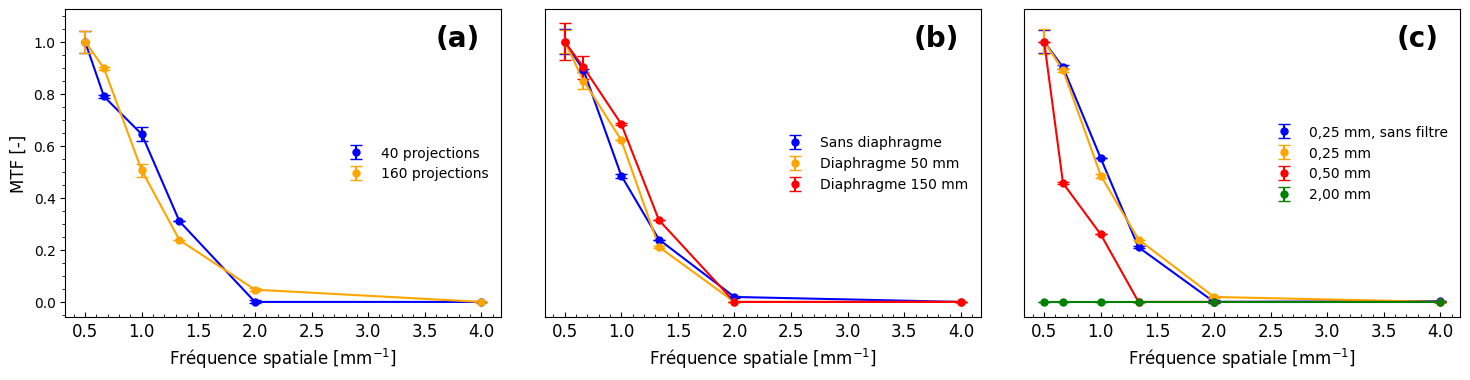

In [70]:
import matplotlib.pyplot as plt

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 4), sharey=True)

# Plot 1
axs[0].errorbar(x_scale, mtfs_partie4_3d_040_025_ramlack_y_v2, yerr=std_mtfs_partie4_3d_160_025_ramlack_y, 
                color="blue", fmt='o', capsize=4, markersize=5, linestyle='', label='40 projections')
axs[0].plot(x_scale, mtfs_partie4_3d_040_025_ramlack_y_v2, color="blue")
axs[0].errorbar(x_scale, mtfs_partie4_3d_160_025_ramlack_y, yerr=std_mtfs_partie4_3d_160_025_ramlack_y, 
                color="orange", fmt='o', capsize=4, markersize=5, linestyle='', label='160 projections')
axs[0].plot(x_scale, mtfs_partie4_3d_160_025_ramlack_y, color="orange")
axs[0].text(0.95, 0.95, '(a)', horizontalalignment='right', verticalalignment='top', transform=axs[0].transAxes, weight='bold', size=20)
axs[0].set_ylabel("MTF [-]", fontsize=12)  # Set y-axis label only for the first subplot
axs[0].set_xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=12)
axs[0].legend(frameon=False, loc='center right')
axs[0].tick_params(axis='y', which='both', left=True, right=False, labelleft=True, labelright=False)
axs[0].tick_params(axis='x', which='both', direction='in', labelsize=12)
axs[0].minorticks_on()

# Plot 2
axs[1].errorbar(x_scale, mtfs_partie4_3d_320_025_y, yerr=std_mtfs_partie4_3d_320_025_y, 
                color="blue", fmt='o', capsize=4, markersize=5, linestyle='', label='Sans diaphragme')
axs[1].plot(x_scale, mtfs_partie4_3d_320_025_y, color="blue")
axs[1].plot(x_scale, mtfs_partie4_3d_320_025_dia050_y, color="orange")
axs[1].errorbar(x_scale, mtfs_partie4_3d_320_025_dia050_y, yerr=std_mtfs_partie4_3d_320_025_dia050_y, 
                color="orange",fmt='o', capsize=4, markersize=5, linestyle='', label='Diaphragme 50 mm')
axs[1].plot(x_scale, mtfs_partie4_3d_320_025_dia150_y, color="red")
axs[1].errorbar(x_scale, mtfs_partie4_3d_320_025_dia150_y, yerr=std_mtfs_partie4_3d_320_025_dia150_y, 
                color="red", fmt='o', capsize=4, markersize=5, linestyle='', label='Diaphragme 150 mm')
axs[1].text(0.95, 0.95, '(b)', horizontalalignment='right', verticalalignment='top', transform=axs[1].transAxes, weight='bold', size=20)
axs[1].set_xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=12)
axs[1].legend(frameon=False, loc='center right')
axs[1].tick_params(axis='both', which='both', direction='in', labelsize=12)
axs[1].minorticks_on()
axs[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

# Plot 3
axs[2].errorbar(x_scale, mtfs_partie4_3d_320_025_nofilter_y , std_mtfs_partie4_3d_320_025_nofilter_y, 
                color="blue", fmt='o', capsize=4, markersize=5, linestyle='', label='0,25 mm, sans filtre')
axs[2].plot(x_scale,mtfs_partie4_3d_320_025_nofilter_y  ,color="blue")
axs[2].errorbar(x_scale, mtfs_partie4_3d_320_025_y, yerr=std_mtfs_partie4_3d_320_025_y, 
                color="orange", fmt='o', capsize=4, markersize=5, linestyle='', label='0,25 mm')
axs[2].plot(x_scale, mtfs_partie4_3d_320_025_y, color="orange")
axs[2].errorbar(x_scale, mtfs_partie4_3d_320_050_y, yerr=std_mtfs_partie4_3d_320_050_y, 
                color="red", fmt='o', capsize=4, markersize=5, linestyle='', label='0,50 mm')
axs[2].plot(x_scale, mtfs_partie4_3d_320_050_y, color="red")
axs[2].errorbar(x_scale, [0,0,0,0,0,0], yerr=[0,0,0,0,0,0], 
                color="green", fmt='o', capsize=4, markersize=5, linestyle='', label='2,00 mm')
axs[2].plot(x_scale,[0,0,0,0,0,0] ,color="green")
axs[2].text(0.95, 0.95, '(c)', horizontalalignment='right', verticalalignment='top', transform=axs[2].transAxes, weight='bold', size=20)
axs[2].set_xlabel("Fréquence spatiale [mm$^{-1}$]", fontsize=12)
axs[2].legend(frameon=False, loc='center right')
axs[2].tick_params(axis='both', which='both', direction='in', labelsize=12)
axs[2].minorticks_on()
axs[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False, labelright=False)

# Adjust layout
plt.subplots_adjust(wspace=0.1)

# Show plot
plt.show()
